In [1]:
import numpy as np
import cv2
import glob
from sklearn.cluster import KMeans
import os
from text_detect import *

try:
    from PIL import Image
except ImportError:
    import Image

In [2]:
# List of a variety of files for preliminary testing
files_to_test = ['100082743.png','290066548.png','51sm64mnQcL._SX342_.jpg','advance-payment-against-proforma-invoice-non-b-nw.jpg','argentina-certificate-of-origin.jpg','ARITACER1.jpg','b3bab39a63b38db79cd20f1422a5a06d.jpg','Certificate_of_origin_example_LRG.jpg','commercial-invoice (1).jpg','commercial-invoice.jpg','download.PNG','images (1).jpg','images (1).PNG','images (2).PNG']

In [6]:
def largest_component(num_labels, labels, stats):
    sizes = np.array(stats[:,cv2.CC_STAT_AREA])
    max_label = 0
    max_size = sizes[0]
    for i in range(0, num_labels):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
            
    img2 = np.zeros(labels.shape)
    img2[labels == max_label] = 255
    return img2

[==================================================================] 274 of 274
C:\Users\szyma\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


80 regions left.


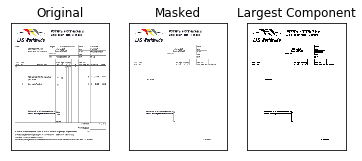

[==================================================================] 113 of 113


21 regions left.


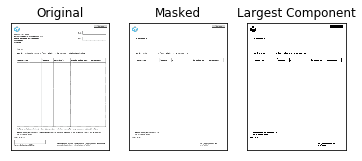

[==================================================================] 670 of 670


276 regions left.


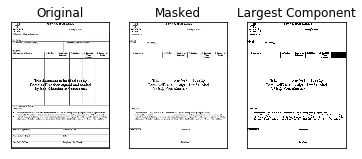

[==================================================================] 550 of 550


305 regions left.


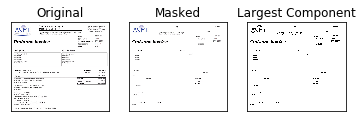

[================================================================] 1039 of 1039


286 regions left.


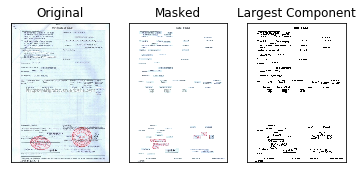

[==================================================================] 624 of 624


225 regions left.


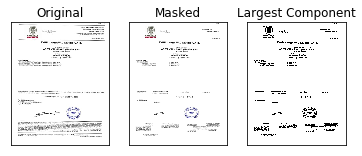

[==================================================================] 357 of 357


87 regions left.


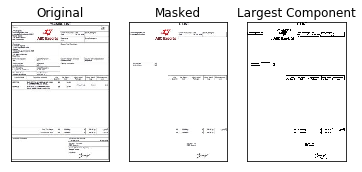

[==================================================================] 601 of 601


146 regions left.


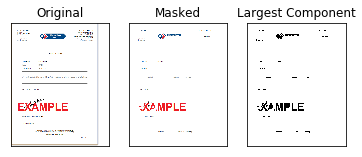

[==================================================================] 853 of 853


98 regions left.


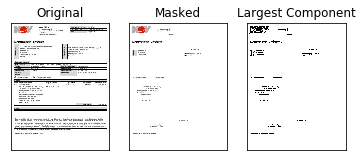

[================================================================] 2335 of 2335


935 regions left.


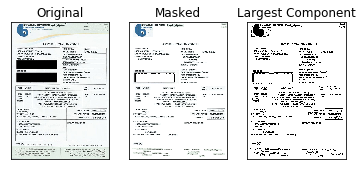

[==================================================================] 111 of 111


20 regions left.


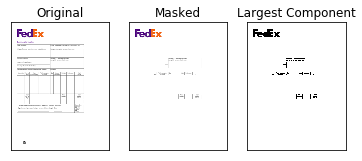

[==================================================================] 227 of 227


14 regions left.


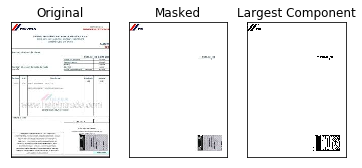

[====================================================================] 91 of 91


2 regions left.


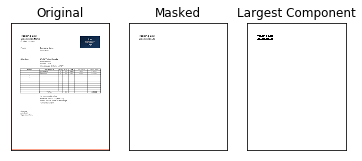

[====================================================================] 70 of 70


17 regions left.


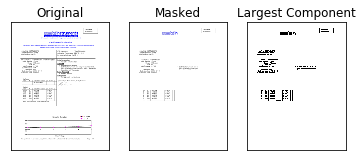

In [7]:
"""
Logo detection algorithm. Start with MSER+SWT as a preprocessing step. It identifies blocks
with text and images. Apply mask to get rid of the regions outside of the boxes identified 
by MSER+SWT in order to get rid of background and contours of tables on documents. To find
candidates for a logo, use a combination of connected components analysis, clustering, and
positioning. 

The order in which the techniques have to be used is to be determined. Current approach 
uses connected component analysis first to identify potential candidates. Clustering and
positioning are then used to get rid of false positives. 

Connected component analysis is applied to the masked image by converting it to grayscale, 
followed by adaptive gaussian thresholding. The candidates for logo are selected by choosing
5% of components with the largest area. 5% should be enough to identify all components of a
logo (its components can get separated during thresholding), but not include too many text
components. 
"""
for filename in files_to_test:
 
    # Detect text and logo using MSER and SWT
    td = TextDetection(filename)
    res = td.detect()
    #mask = cv2.bitwise_not(res)
    # Mask the original image with the areas identified by MSER+SWT
    masked = cv2.bitwise_and(td.img,td.img,mask = res)
    # Convert all the black areas to white. Happens in two steps,
    # to make areas outside of the boxes white
    masked[np.where((masked==[0,0,0]).all(axis=2))] = [255,255,255]
    #masked[np.where((masked==[255,255,255]).all(axis=2))] = [0,0,0]
    # Convert to grayscale and use Adaptive Gaussian Thresholding to create a binary image
    graymasked = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY)
    binaryimg = cv2.adaptiveThreshold(graymasked,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    
    # Finds connected components on the binary masked image
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binaryimg)
    # Finds the largest connected component
    largestCompImg = largest_component(num_labels, labels, stats)
    
    #readClusterShow(original_masked)
    pltShow((td.img, "Original"), (masked, "Masked"), (largestCompImg, "Largest Component"))
    #cv2.imshow('binary',binaryimg)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()    
    
    # TextDetection assumes input is BGR and converts to RGB, this instruction converts
    # it back to RGB. It is the output of the preprocessing MSER + SWT step
    original_masked = cv2.cvtColor(masked, cv2.COLOR_RGB2BGR)

In [ ]:
def longestChild(contours, hierarchy):
    # Find the longest contour
    length_longest = 0
    # Index to iterate through the hierarchy of the contours
    i = 0
    # Initially the longest contour is not found
    longest_contour_idx = None
    for contour in contours:
        # Check that the contour has no children
        # hierarchy[i][2] contains the index of the first child
        # it is set to -1 if the contour has no children
        if hierarchy[0][i][2] == -1:
            # Check the length of the contour and update
            # the longest contour, if appropriate
            length = cv2.arcLength(contour, True)
            if length>length_longest:
                length_longest = length
                longest_contour_idx = i
        i+=1
    # If a contour without children was not found trigger an error
    assert longest_contour_idx!=None, 'Contour not found'
    return longest_contour_idx


In [ ]:
# Try clustering with just the saturation value
for filename in files_to_retest:
    readClusterShow(filename)

In [ ]:
# Read all images into a list
image_list = []
for ext in ["jpg","gif","png"]:
    for filename in glob.glob('C:/users/szyma/Documents/Data Science projects/Logos/logo_images/*.%s' % ext) : #assuming png
        img = cv2.imread(filename)
        image_list.append(img)

In [ ]:
# For each pixel create a vector containing its distance from ends of Lightness spectrum, 
# Saturation and x- and y-coordinates
def pixelVectors(hls):
    row_idx = 0
    column_idx = 0
    # Create an empty matrix for storing pixel data
    pixel_data = np.zeros([len(hls), len(hls[0]), 3])
    for row in hls:
        for pixel in row:
            # Put the vector for that pixel in the matrix
            # To create the vector, use the saturation, distance from the end of lightness spectrum and 
            # coordinates. pixel[1] contains lighntess, pixel[2] saturation
            pixel_data[row_idx][column_idx] = [pixel[2],column_idx,row_idx]
            column_idx+=1
        column_idx = 0
        row_idx+=1
    # Flatten the matrix with the pixel data into a list of vectors
    pixel_data = pixel_data.reshape(len(pixel_data)*len(pixel_data[0]), len(pixel_data[0][0]))
    return pixel_data

# Normalise the vectors using means and standard deviations
def normalisePixels(pixel_data):
    means = np.mean(pixel_data, axis=0)
    stds = np.std(pixel_data, axis=0)
    normed_pixels = []
    for row in pixel_data:
        normed_pixels.append((row-means)/stds)
    return normed_pixels,means,stds

# The cluster with the logo is the one with higher Saturation 
# this chooses colourful regions over black and white
def findLogoCluster(cluster_centers):
    if (cluster_centers[0][0]) > (cluster_centers[1][0]):
        logo_cluster = 0
    else:
        logo_cluster = 1
    return logo_cluster

# With neon green points mark on the original image what 
# points are in the cluster identified as the logo
neon_green = [57, 255, 20]
def showLogoCluster(normed_pixels, kmeans, means, stds, img, logo_cluster):
    for point in normed_pixels:
        # Convert to the original points using the means and standard deviations
        if kmeans.predict([point]) == logo_cluster:
            # If belongs to the logo cluster find the location on the original
            # image and change it to neon green
            # First check it is not outside of the image length (rouning error)
            if point[1]*stds[1]+means[1] > len(img)-2:
                xcoord = len(img)-1
            else:
                xcoord = point[1]*stds[1]+means[1]
            if point[2]*stds[2]+means[2] > len(img[0])-2:
                ycoord = len(img[0])-1
            else:
                ycoord = point[2]*stds[2]+means[2]
            # Change colour to neon green
            img[int(round(ycoord)), int(round(xcoord))] = neon_green
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()    

def readClusterShow(img):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Get the vectors for clustering
    pixel_data = pixelVectors(hls)
    normed_pixels, means, stds = normalisePixels(pixel_data)
    # Run K-means clustering on the normalised vectors
    # Assume 2 clusters - one for logo and one for the rest of the document
    kmeans = KMeans(n_clusters=2, random_state=0).fit(normed_pixels)
    cluster_centers = kmeans.cluster_centers_
    print(cluster_centers*stds+means)
    logo_cluster = findLogoCluster(cluster_centers)
    showLogoCluster(normed_pixels, kmeans, means, stds, img, logo_cluster)